In [1]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

# Data manipulation libraries
import numpy as np
import pandas as pd

# Jupyter magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler

# Custom modules
from ssa import *
from gp_regressor import GPRegressor

# Scikit-learn components
from sklearn.gaussian_process.kernels import DotProduct, RBF, WhiteKernel
from sklearn.linear_model import Ridge

# Darts - Time Series components
from darts import TimeSeries, concatenate
from darts.datasets import AirPassengersDataset
from darts.metrics import mape, rmse
from darts.utils.missing_values import extract_subseries
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

# Darts - Models
from darts.models import (
    XGBModel,
    ExponentialSmoothing,
    LinearRegressionModel,
    RandomForest,
    TCNModel,
)

# Darts - Data processing
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import MissingValuesFiller, Scaler

In [2]:
data = pd.read_parquet("../data/afrr_price.parquet")

In [3]:
data = data[['wind_offshore_dayahead', 'wind_onshore_dayahead',
       'solar_dayahead','aFRR_DownCapPriceEUR', 'aFRR_UpCapPriceEUR', 'load_forecasts',
       'da_price', 'prod_unbalance']]


In [4]:
data.index = data.index.tz_localize(None)

In [5]:
ts = data["aFRR_UpCapPriceEUR"]
ssa_ts = mySSA(data["aFRR_UpCapPriceEUR"])
ssa_ts.embed(embedding_dimension=128, suspected_frequency=24, verbose=True)
ssa_ts.decompose(True)
components = [i for i in range(10)]
ts_clean = ssa_ts.view_reconstruction(*[ssa_ts.Xs[i] for i in components], names=components, return_df=True, plot=False)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 3265)
Complete dimension	: (120, 3265)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 113
Characteristic of projection	: 0.9997


In [6]:
data["aFRR_UpCapPriceEUR_cl"] = ts_clean.values

In [7]:
afrr_pr = 'aFRR_UpCapPriceEUR_cl'
afrr_pr_orig = 'aFRR_UpCapPriceEUR'


exog_cols = ['wind_offshore_dayahead', 'wind_onshore_dayahead', 
            'solar_dayahead', 'load_forecasts', 'da_price', 'prod_unbalance']



afrr_pr_ts = TimeSeries.from_series(data[afrr_pr], freq="1h")
afrr_pr_ts_orig = TimeSeries.from_series(data[afrr_pr_orig], freq="1h")
exog_ts = TimeSeries.from_dataframe(data[exog_cols], freq="1h")

#filler = MissingValuesFiller()
scaler_target_ts = Scaler()
scaler_exog_ts = Scaler()
filler_target_ts = MissingValuesFiller()
filler_exog_ts = MissingValuesFiller()

afrr_pr_scaler = Pipeline([scaler_target_ts])
exog_ts_preprocess = Pipeline([scaler_exog_ts])

afrr_pr_ts_filled = filler_target_ts.transform(afrr_pr_ts)
exog_ts_filled = filler_exog_ts.transform(exog_ts)

afrr_pr_ts_scl = afrr_pr_scaler.fit_transform(afrr_pr_ts_filled)
exog_ts_scl = exog_ts_preprocess.fit_transform(exog_ts_filled)

# Using your original timestamps
train_start = pd.Timestamp("2024-10-01 22:00:00")
#cal_start = pd.Timestamp("2025-01-09 22:00:00")
test_start = pd.Timestamp("2025-01-09 22:00:00")
test_end = pd.Timestamp("2025-02-20 22:00:00")

# For target series with original variable names
afrr_pr_ts_scl_train = afrr_pr_ts_scl[train_start : test_start - afrr_pr_ts_scl.freq]
afrr_pr_ts_scl_test = afrr_pr_ts_scl[test_start : test_end]

afrr_pr_ts_orig_train = afrr_pr_ts_orig[train_start : test_start - afrr_pr_ts_scl.freq]
afrr_pr_ts_orig_test = afrr_pr_ts_orig[test_start : test_end]

# For exogenous series with original variable names
exog_ts_scl_train = exog_ts_scl[train_start : test_start - exog_ts_scl.freq]
exog_ts_scl_test = exog_ts_scl[test_start : test_end]


In [8]:
horizon = 24

quantiles=[0.5]
output_chunk_length = 24

ts_encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'tz': 'UTC'
}


#################################### Gaussian Process Model

kernel =  DotProduct()  + WhiteKernel()

model_gp = GPRegressor(
    lags=24,                    
    lags_past_covariates=24, 
	#lags_future_covariates=[0, 1, 2],   
    output_chunk_length=24,     
    kernel=kernel)

model_lr = LinearRegressionModel(output_chunk_length=output_chunk_length,     
                                lags=list(range(-1, -240, -1)), 
                                lags_past_covariates=list(range(-1, -24, -1)),
                                lags_future_covariates=list(range(1, 2, 1))
                                )

print ('Fitting Gaussian Process Model...')
model_gp.fit(
    afrr_pr_ts_scl_train,
    past_covariates=exog_ts_scl_train)



print ('Historical Forecast Using Fitted Gaussian Process Model...')
hist_forecasts_gp = model_gp.historical_forecasts(
                                                    series=afrr_pr_ts_scl_test,
                                                    past_covariates=exog_ts_scl_test,
                                                    #future_covariates=exog_ts_scl,
                                                    start=0.05,
                                                    forecast_horizon=horizon,
                                                    predict_likelihood_parameters=False, 
                                                    last_points_only=False,
                                                    stride=24,
                                                    retrain=False,
                                                    verbose=True)
hist_forecasts_gp = concatenate(hist_forecasts_gp)
hist_forecasts_gp = hist_forecasts_gp.with_columns_renamed('aFRR_UpCapPriceEUR_cl', 'afrr_up_cap_price_gp_hat')
hist_forecasts_gp = afrr_pr_scaler.inverse_transform(hist_forecasts_gp)


#################################### Linear Model
print ('Fitting Linear Model...')
model_lr.fit(
    afrr_pr_ts_scl_train,
    past_covariates=exog_ts_scl_train,
    future_covariates=exog_ts_scl_train)

print ('Historical Forecast Using Linear Model...')
hist_forecasts_lr = model_lr.historical_forecasts(
                                                    series=afrr_pr_ts_scl_test,
                                                    past_covariates=exog_ts_scl_test,
                                                    future_covariates=exog_ts_scl_test,
                                                    start=0.05,
                                                    forecast_horizon=horizon,
                                                    predict_likelihood_parameters=False, 
                                                    last_points_only=False,
                                                    stride=24,
                                                    retrain=True,
                                                    verbose=True)
hist_forecasts_lr = concatenate(hist_forecasts_lr)
hist_forecasts_lr = afrr_pr_scaler.inverse_transform(hist_forecasts_lr)
hist_forecasts_lr = hist_forecasts_lr.with_columns_renamed('aFRR_UpCapPriceEUR_cl', 'afrr_up_cap_price_lr_hat')

#################################### XGBoost Model
model_xgboost = XGBModel(
                lags=48,
                lags_past_covariates=24,
                add_encoders= ts_encoders,
                output_chunk_length=output_chunk_length)

print ('Fitting XGBoost Model...')
model_xgboost.fit(
                  afrr_pr_ts_scl_train,
                  past_covariates=exog_ts_scl_train)


print ('Historical Forecast Using XGBoost Model...')
hist_forecasts_xgboost = model_xgboost.historical_forecasts(
                                                    series=afrr_pr_ts_scl_test,
                                                    past_covariates=exog_ts_scl_test,
                                                    start=0.05,
                                                    forecast_horizon=horizon,
                                                    predict_likelihood_parameters=False, 
                                                    last_points_only=False,
                                                    stride=24,
                                                    retrain=True,
                                                    verbose=True)

hist_forecasts_xgboost = concatenate(hist_forecasts_xgboost)
hist_forecasts_xgboost = afrr_pr_scaler.inverse_transform(hist_forecasts_xgboost)
hist_forecasts_lr = hist_forecasts_lr.with_columns_renamed('aFRR_UpCapPriceEUR_cl', 'afrr_up_cap_price_xgboost_hat')


hist_afrr_pr = afrr_pr_scaler.inverse_transform(afrr_pr_ts_scl_test)

Fitting Gaussian Process Model...


KeyboardInterrupt: 

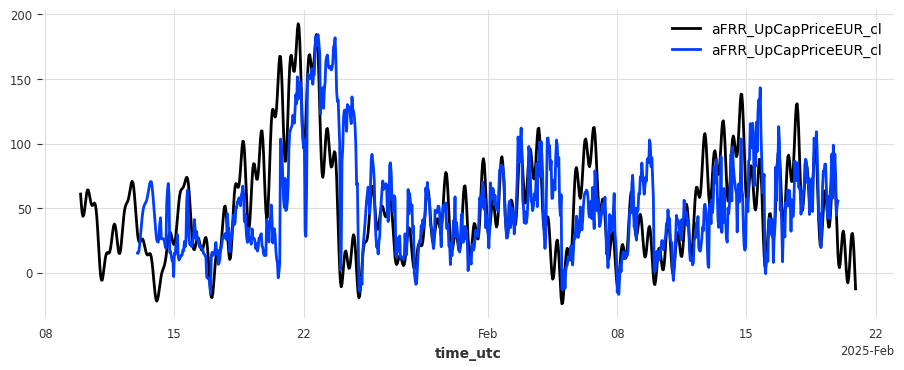

In [ ]:
hist_afrr_pr.plot()
#hist_forecasts_gp.plot()
#hist_forecasts_lr.plot()
hist_forecasts_xgboost.plot()
plt.show()